# HySwash: A hybrid method for nearshore wave processes

![sketch](../assets/hyswash-sketch.png)

## 1 Variable Sampling and Selection

It is essential to carefully select the variables that will feed into the presented metamodel. The numerical model SWASH (Simulating WAves till SHore) is designed to solve the Navier-Stokes equations numerically, relying on key hydrodynamic input variables. Drawing from previous research on hydrodynamic modeling, it has been proven that the necessary variables encompass:

- Significant wave height (Hs) "Hs", "Hs_L0", "Wv","hv","Nv"
- Wave slope (Hs_L0)
- Vegetation Lenght (Wv)
- Vegetation Height (hv)
- Plants density (Nv)


![profile](../assets/hyswash-profile.png)


The first step in implementing our metamodel iWvolves generating and selecting specific representative cases that combine the variables previously identified. These combinations will accurately simulate realistic sea states in SWASH. Therefore, our task is to create realistic combinations of these variables to feed into the numerical model later on.

### Configure environment and create bathymetry

In [ ]:
import os
import os.path as op
import numpy as np
import utils.plotting
import bluemath_tk.topo_bathy.profiles
from bluemath_tk.datamining.lhs import LHS
from bluemath_tk.datamining.mda import MDA
from bluemath_tk.waves.series import waves_dispersion 
from bluemath_tk.wrappers.swash.swash_wrapper import HySwashVeggyModelWrapper
from bluemath_tk.core.io import load_model
from bluemath_tk.core.plotting.scatter import plot_scatters_in_triangle
import xarray as xr
import matplotlib.pyplot as plt
from utils.plotting import animate_case_propagation
from IPython.display import HTML

root_dir = os.getcwd()
output_dir = os.path.join(root_dir, "output_Veggy_Hs_mono")
templates_dir = os.path.join(root_dir, "templates", "HyVeggy")
export_dir = op.join(root_dir, "exported_Veggy_Hs_mono")
os.makedirs(export_dir,exist_ok=True)

lhs_samples=11000
mda_samples=1000
scatter_points_thick=1

# Uncomment these lines if you are going to run the NoteBook in codespaces
# mda_samples=4
# scatter_points_thick=10


Create bathymetry

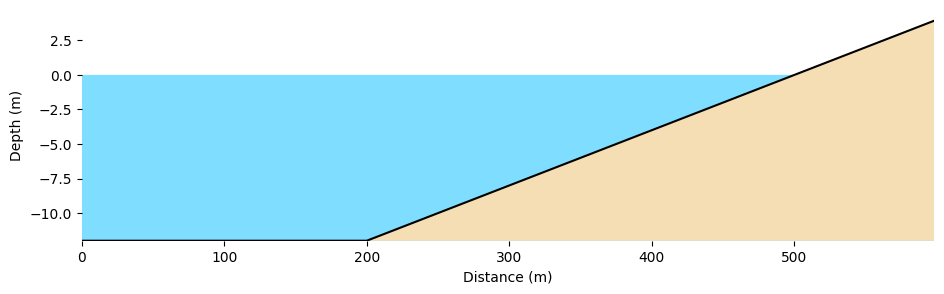

In [7]:
# Bathymetry parameters
h0 = 12               #offshore depth (m)
bCrest = 5.          #beach heigh (m)
m=12/300            # profile slope
Wfore = 200       #flume length before fore toe (m)

#depth_array=bluemath_tk.topo_bathy.profiles.reef(1,20,1/20,1/20,300,500,5,2)
depth_array=bluemath_tk.topo_bathy.profiles.linear(1,h0,bCrest,m,Wfore)
# Cut the depth array to the desired length (600 meters)
depth_array=depth_array[0:599]
np.savetxt(os.path.join(templates_dir,"depth.bot"),depth_array)
utils.plotting.plot_depthfile(depthfile=op.join(templates_dir, "depth.bot"))

### 1.1. Latin Hypercube Sampling (LHS)

The Latin Hypercube Sampling (LHS) is a statistical technique designed to efficiently select parameter values across multiple dimensions while ensuring controlled randomness in the sampled data. To implement this technique, we start by establishing the limits for each variable.

In [8]:
variables_to_analyse_in_metamodel = ["Hs", "Hs_L0", "Wv","hv","Nv"]
lhs_parameters = {
    "num_dimensions": 5,
    "num_samples": lhs_samples,
    "dimensions_names": variables_to_analyse_in_metamodel,
    "lower_bounds": [0.5, 0.003, 0, 0, 0],
    "upper_bounds": [3, 0.01, 200, 1.5, 1000],
}

lhs = LHS(
    num_dimensions=lhs_parameters.get("num_dimensions"),
)

lhs_dataset = lhs.generate(
    dimensions_names=lhs_parameters.get("dimensions_names"),
    lower_bounds=lhs_parameters.get("lower_bounds"),
    upper_bounds=lhs_parameters.get("upper_bounds"),
    num_samples=lhs_parameters.get("num_samples"),
)

# Calculation of the wave length and other parameters to avoid unphysical values
df_centroids= lhs_dataset.copy()
df_centroids['Tp'] = np.sqrt((df_centroids['Hs'].values * 2 * np.pi) / (9.806 * df_centroids['Hs_L0']))
df_centroids['L'] = [waves_dispersion(i, h0)[0]  for i in df_centroids['Tp']]
df_centroids['h/L'] = h0 / df_centroids['L']
df_centroids['kh'] = (2 * np.pi/df_centroids['L']) * h0
df_centroids = df_centroids.loc[(df_centroids['kh'] < 1) & (df_centroids['Tp'] > 7)]
df_centroids = df_centroids.loc[(df_centroids['h/L'] < 0.5)]
df_dataset=lhs_dataset.loc[df_centroids.index]

### 1.2. Maximum Dissimilarity Algorithm (MDA)

The high computational cost of propagating the entire hindcast dataset requires statistical tools to reduce the set of data to a number of representative cases to perform hybrid downscaling. The maximum dissimilarity algorithm (MDA) defined in the work of Camus et al., 2011, is implemented for this purpose.<br>
    <br>
Given a data sample $X=\{x_{1},x_{2},…,x_{N}\}$ consisting of $N$ $n$-dimensional vectors, a subset of $M$ vectors $\{v_{1},…,v_{M}\}$ representing the diversity of the data is obtained by applying this algorithm. The selection starts initializing the subset by transferring one vector from the data sample ${v_{1}}$. The rest of the $M-1$ elements are selected iteratively, calculating the dissimilarity between each remaining data in the database and the elements of the subset and transferring the most dissimilar one to the subset. The process finishes when the algorithm reaches $M$ iterations.

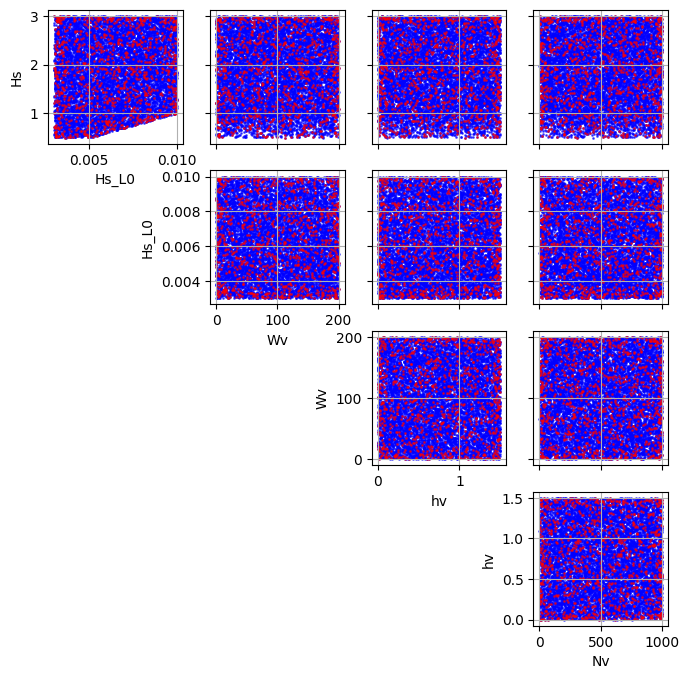

In [9]:
mda_parameters = {"num_centers": mda_samples}

mda = MDA(num_centers=mda_parameters.get("num_centers"))
mda.fit(data=df_dataset, normalize_data=True)
[fig,axes]=mda.plot_selected_centroids(s=scatter_points_thick)
fig.set_size_inches(8, 8)

mda._exclude_attributes=[]
mda.save_model(
    model_path=op.join(export_dir, "mda_model.pkl"),
)

Plot Tp instead of Hs/L0

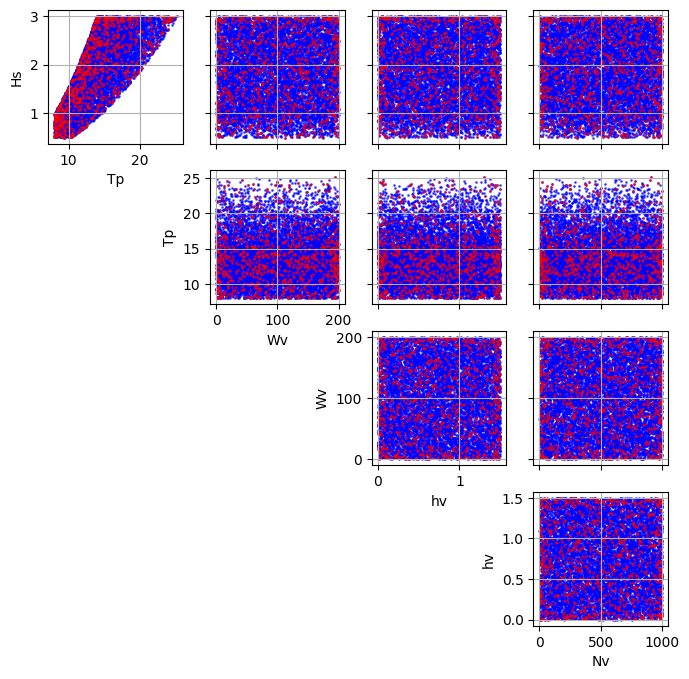

In [10]:
df_centroids = mda.centroids.copy()
df_lhs_data=mda.data.copy()
df_centroids['Tp'] = np.sqrt((df_centroids['Hs'].values * 2 * np.pi) / (9.806 * df_centroids['Hs_L0']))
df_lhs_data['Tp'] = np.sqrt((df_lhs_data['Hs'].values * 2 * np.pi) / (9.806 * df_lhs_data['Hs_L0']))
df_centroids = df_centroids.drop(columns=["Hs_L0"])
df_lhs_data = df_lhs_data.drop(columns=["Hs_L0"])
df_centroids = df_centroids[['Hs', 'Tp', 'Wv', 'hv', 'Nv']]
df_lhs_data = df_lhs_data[['Hs', 'Tp', 'Wv', 'hv', 'Nv']]

fig,axes=plot_scatters_in_triangle(dataframes=[df_lhs_data,df_centroids],s=scatter_points_thick,data_colors=["blue","red"])
fig.set_size_inches(8, 8)

## 2. Numerical model SWASH

Once the hydrodynamic cases to be numerically simulated have been selected through the MDA algorithm, we proceed to launch these cases in SWASH. It is a versatile numerical tool designed to simulate a non-hydrostatic, phase-resolving wave model capable of simulating waves from deep waters to the shoreline, modeling wave breaking, bottom friction, wave- induced setup and runup, and the generation and propagation of infragravity waves (Delft University of Technology, n. d.).

In [11]:
os.environ["OMP_NUM_THREADS"] = "1"  
#from utils.ChySwash import ChySwashModelWrapper
from bluemath_tk.wrappers.swash.swash_wrapper import HySwashVeggyModelWrapper
import os.path as op

metamodel_parameters = mda.centroids.to_dict(orient="list")


fixed_parameters = {
    "dxinp": 1,         # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "Plants_end": 400,  # Friction start cell
    "comptime": 300,     # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 60, # number of nodes per wavelength
}

swash_model = HySwashVeggyModelWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=depth_array
    )
swash_model.save_model(
    model_path=op.join(export_dir, "swash_model.pkl")
)

/opt/conda/lib/python3.12/importlib/__init__.py:131: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2025-05-30 06:19:10,199 - HySwashVeggyModelWrapper - WARNING - Parameter Wv is not in the default_parameters
2025-05-30 06:19:10,199 - HySwashVeggyModelWrapper - WARNING - Parameter hv is not in the default_parameters
2025-05-30 06:19:10,200 - HySwashVeggyModelWrapper - WARNING - Parameter Nv is not in the default_parameters


### Build, run and postprocess cases

In [15]:
swash_model.build_cases()
swash_model.run_cases_in_background(launcher="serial", num_workers=2)

# If you want to run the cases in the cluster, you can use the following commands:
# sbatch -array=0-99 RunSwash.sh
# sbatch -array=0-99 Postprocess.sh

Monitor cases

In [9]:
swash_model.monitor_cases()

,Case,Status
0,0000,33 %
1,0001,18 %
2,0002,No run.tab
3,0003,No run.tab


## 4. Data Processing

The primary output variable generated by SWASH include the time series of water level along the profile. This output serves as crucial indicator of the hydrodynamic processes. From this SWASH output, we compute various other key variables. Different output quantities will be given here to go over the different wave transformation processes including wave propagation, dispersion, flooding and drying, moving shoreline, surf-beat, infragravity waves, set-up induced by wave breaking, run-up and overtopping discharge. 

- To this end, the time-dependent surface elevation is stored at every grid point for every time step. After removing the warmup time from the sea surface series, a FFt is applied to obtain its representation in the frequency domain. A further classification is given by spliting the wave frequency into incident waves IC (0.04 - 1), infragravity waves IG (0.004 - 0.04) and very low frequency VLF (0.001 - 0.004). 

- The run-up heigh is computed by the intersection between free surface and bottom level considering a minimun  depth of 1cm after each time step. 

- The mean wave overtopping discharge q (ms/l) is outputted at the highest elevation point.

After each simulation, the postprocess steps creates 2 files in the directory of the case:
 
 - output.nc: It contains the case run.tab and output.tab in netCDF format.
 - output_postprocessed.nc: It contains the variables selected by the users. In our case: 'Ru2', 'Runlev', 'Msetup', 'Hrms', 'Hfreqs'.

The postprocessor also allows the creation of a single netCDF file with the postprocessed output of every case. It locates it in the output_dir.

In [16]:
swash_model.list_available_postprocess_vars()
swash_model.load_cases()
postprocessed_output = swash_model.postprocess_cases(write_output_nc=True)

# Join the postprocessed output:
#postprocessed_output = swash_model.postprocess_cases(write_output_nc=True,overwrite_output_postprocessed=False,overwrite_output=False)
#postprocessed_output = swash_model.postprocess_cases(overwrite_output_postprocessed=False,overwrite_output=False)

### Analyse postprocessed output

Save the output of simulations that do not contains Nans in output_postprocess_clean.nc and get the case_num of simulations failed or containning Nans and plot them.

In [54]:
bad=list(set(np.arange(0,mda_samples-1))-set(postprocessed_output.case_num.values))
ok=[]
for case_num in postprocessed_output.case_num.values:
    postprocessed_case = postprocessed_output.sel(case_num=case_num)
    #for var in postprocessed_case.data_vars:
    for var in ["Hrms"]:
        if postprocessed_case[var].isnull().values.any():
            # print the variable name and the first occurrence of NaN
            nan_indices = np.where(np.isnan(postprocessed_case[var].values))
            bad.append(case_num)
        else:
            ok.append(case_num)

Create a NetCDF file with all the postprocessed outputs that do not contain Nans

In [20]:
post_clean=postprocessed_output.copy(deep=True)
# get unique values of ok
post_clean=post_clean.sel(case_num=ok)
post_clean.to_netcdf(
    os.path.join(export_dir, "output_postprocessed_clean.nc")
)

#### Run the failed cases again with modified parameters
In our case the bad array contain the following cases: 34,180,216,258,282,368,375,442,459,467,519,581,687,691,699,836,838,867,889,945

We will try to run the model again increasing the n_nodes_per_wavelength from 60 to 100 and the TIMEI (in the INPUT file) from 0.5 to 0.3 to avoid numerical inestabilities. 

In [ ]:
fixed_parameters = {
    "dxinp": 1,         # bathymetry grid spacing  # Friction manning coefficient (m^-1/3 s)
    "Plants_end": 400,  # Friction start cell
    "comptime": 300,     # Simulation duration (s)
    "warmup": 300,  # Warmup duration (s)
    "n_nodes_per_wavelength": 100, # number of nodes per wavelength
}

swash_model2 = HySwashVeggyModelWrapper(
    templates_dir=templates_dir,
    metamodel_parameters=metamodel_parameters,
    fixed_parameters=fixed_parameters,
    output_dir=output_dir,
    depth_array=depth_array
    )

swash_model2.build_cases(num_workers=30,cases_to_build=bad)
swash_model2.run_cases_in_background(launcher="serial", num_workers=2,cases_to_run=bad)
# Create a new postprocessed output with all the cases. 
postprocessed_output = swash_model2.postprocess_cases(write_output_nc=True,overwrite_output_postprocessed=False,overwrite_output=False)

# After running the cases only 3 simulations have failed.

#### To avoid running again the workflow load the MDA and SWASH models and the postprocessed_output

In [11]:
# Load the MDA model
mda = load_model(op.join(export_dir, "mda_model.pkl"))

# Load the HySwash model
swash_model = load_model(op.join(export_dir, "swash_model.pkl"))

# Load postprocessed data from NetCDF File in case we do not want to postprocess again
postprocessed_output = xr.open_dataset(op.join(export_dir, "output_postprocessed_clean.nc"))

#### Plot postprocessed output for different cases

Choose the variable (Runlev, Msetup, Hrms, Hs, Hss, ig, Hvlf) and cases you want to visualize

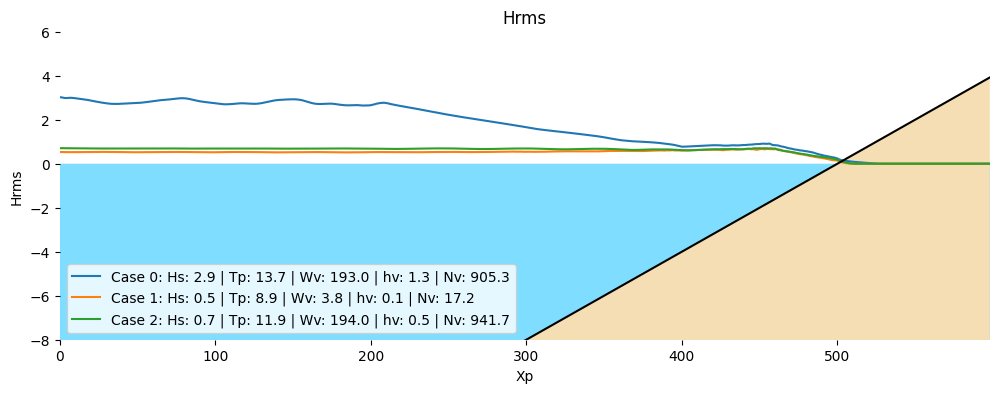

In [58]:
postprocessed_var="Hrms" 
cases=[0,1,2]

fig,ax=plt.subplots(1,1,figsize=(12,4))
utils.plotting.plot_depthfile(depthfile=op.join(templates_dir, "depth.bot"), ax=ax)
for case_num in cases:
    values=df_centroids.iloc[case_num].to_dict()
    postprocessed_output.isel(case_num=case_num)[postprocessed_var].plot(ax=ax, label=f"Case {case_num}: {" | ".join(f"{k}: {v:.1f}" for k, v in values.items())}")
ax.set_ylim(-8,6)
ax.set_title(postprocessed_var)
ax.legend()


### Total Water Elevation Visualization
Fill case_num with the number of the simulation you want to visualize



In [17]:
case_num = 0


case_num_s = str(case_num).zfill(4)
output_nc=xr.open_dataset(op.join(output_dir, case_num_s, "output.nc"))
data=output_nc[["Watlev"]].squeeze()
ani = animate_case_propagation(
    data,
    depth_array,
    tini=0,
    tend=300,
    tstep=5,
    figsize=(11, 3),
)
HTML(ani.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
